# Multiple single-step forecast models

models studied in Zoumpekas et al (2020)

In [1]:
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input, Conv1D, LSTM, GRU, Bidirectional, Dropout, Flatten
from tensorflow.keras import Model, Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

l2reg = l2(l2=0.0001)

cnn2 = Sequential([
    Input(shape=(6,2), name="conv1d_1_input"),
    Conv1D(80, kernel_size=3, strides=1, activation="relu", kernel_regularizer=l2reg, bias_regularizer=l2reg, name="conv1d_1"),
    Dropout(0.20, name="dropout_1"),
    Conv1D(2, kernel_size=3, strides=2, activation="linear", kernel_regularizer=l2reg, bias_regularizer=l2reg, name="conv1d_2"),
    Flatten(),
    Dense(1, kernel_regularizer=l2reg, bias_regularizer=l2reg, name="dense_1")
])

cnn3 = Sequential([
    Input(shape=(6,2), name="conv1d_1_input"),
    Conv1D(80, kernel_size=3, strides=1, activation="relu", kernel_regularizer=l2reg, bias_regularizer=l2reg, name="conv1d_1"),
    Dropout(0.20, name="dropout_1"),
    Conv1D(40, kernel_size=2, strides=1, activation="relu", kernel_regularizer=l2reg, bias_regularizer=l2reg, name="conv1d_2"),
    Dropout(0.20, name="dropout_2"),
    Conv1D(2, kernel_size=2, strides=2, activation="linear", kernel_regularizer=l2reg, bias_regularizer=l2reg, name="conv1d_3"),
    Flatten(),
    Dense(1, kernel_regularizer=l2reg, bias_regularizer=l2reg, name="dense_1")
])

lstm = Sequential([
    Input(shape=(6,2), name="lstm_1_input"),
    LSTM(50, activation="tanh", recurrent_dropout=0.2, kernel_regularizer=l2reg, bias_regularizer=l2reg, name="lstm_1"),
    Dropout(0.20, name="dropout_1"),
    Dense(1, kernel_regularizer=l2reg, bias_regularizer=l2reg, name="dense_1")
])

slstm = Sequential([
    Input(shape=(6,2), name="lstm_1_input"),
    LSTM(50, activation="tanh", return_sequences=True, recurrent_dropout=0.2, kernel_regularizer=l2reg, bias_regularizer=l2reg, name="lstm_1"),
    Dropout(0.20, name="dropout_1"),
    LSTM(50, activation="tanh", recurrent_dropout=0.2, kernel_regularizer=l2reg, bias_regularizer=l2reg, name="lstm_2"),
    Dropout(0.20, name="dropout_2"),
    Dense(1, kernel_regularizer=l2reg, bias_regularizer=l2reg, name="dense_1")
])

bilstm = Sequential([
    Input(shape=(6,2), name="lstm_1_input"),
    Bidirectional(LSTM(50, activation="tanh", recurrent_dropout=0.2, kernel_regularizer=l2reg, bias_regularizer=l2reg, name="lstm_1")),
    Dropout(0.20, name="dropout_1"),
    Dense(1, kernel_regularizer=l2reg, bias_regularizer=l2reg, name="dense_1")
])

gru = Sequential([
    Input(shape=(6,2), name="gru_1_input"),
    GRU(50, activation="tanh", recurrent_dropout=0.2, kernel_regularizer=l2reg, bias_regularizer=l2reg, name="gru_1"),
    Dropout(0.20, name="dropout_1"),
    Dense(1, kernel_regularizer=l2reg, bias_regularizer=l2reg, name="dense_1")
])

2021-12-14 00:35:32.549592: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-12-14 00:35:32.549617: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: acer
2021-12-14 00:35:32.549623: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: acer
2021-12-14 00:35:32.549713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2021-12-14 00:35:32.549734: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2021-12-14 00:35:32.549740: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2021-12-14 00:35:32.549981: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations

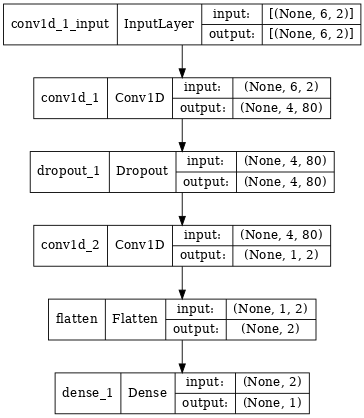

In [2]:
from tensorflow.keras.utils import plot_model
plot_model(cnn2, show_shapes=True, show_layer_names=True, dpi=64)

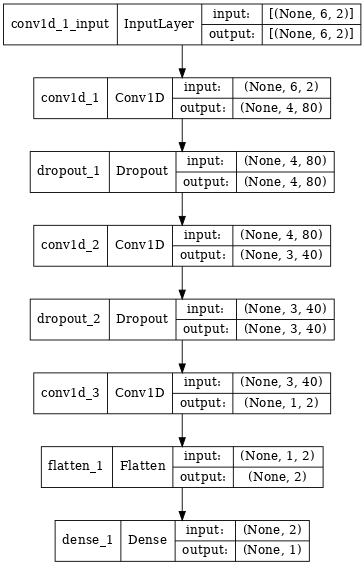

In [3]:
plot_model(cnn3, show_shapes=True, show_layer_names=True, dpi=64)

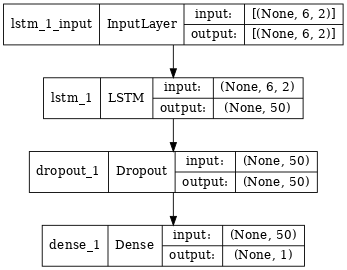

In [4]:
plot_model(lstm, show_shapes=True, show_layer_names=True, dpi=64)

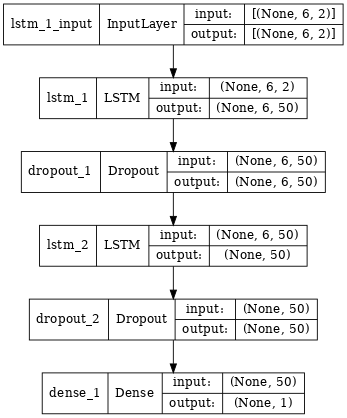

In [5]:
plot_model(slstm, show_shapes=True, show_layer_names=True, dpi=64)

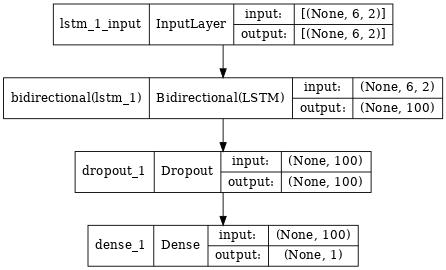

In [6]:
plot_model(bilstm, show_shapes=True, show_layer_names=True, dpi=64)

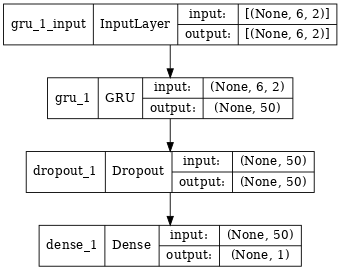

In [7]:
plot_model(gru, show_shapes=True, show_layer_names=True, dpi=64)

In [8]:
# Build data generator
def datagen(data, seq_len, batch_size, targetcol):
    "As a generator to produce samples for Keras model"
    # Learn about the data's features and time axis
    input_cols = [c for c in data.columns if c != targetcol]
    # Infinite loop to generate a batch
    batch = []
    while True:
        # Pick one position, then clip a sequence length
        while True:
            t = random.choice(data.index)
            n = (data.index == t).argmax()
            if n-seq_len+1 < 0:
                continue # this sample is not enough for one sequence length
            frame = data.iloc[n-seq_len+1:n+1][input_cols].T
            target = data.iloc[n+1][targetcol]
            # extract 2D array
            batch.append([frame, data.iloc[n+1][targetcol]])
            break
        # if we get enough for a batch, dispatch
        if len(batch) == batch_size:
            X, y = zip(*batch)
            yield np.array(X, dtype="float32"), np.array(y, dtype="float32")
            batch = []
            
def read_data(filename):
    # Read data into pandas DataFrames
    X = pd.read_csv(filename, index_col="Timestamp")
    X.index = pd.to_datetime(X.index, unit="s")
    # target is next day closing price
    cols = X.columns
    X["Target"] = X["Close"].shift(-1)
    X.dropna(inplace=True)
    return X

In [9]:
# Read data
TRAINFILE = "dataset/Ethereum_price_data_train.csv"
VALIDFILE = "dataset/EThereum_price_data_test_29_May_2018-30_December_2018.csv"

df_train = read_data(TRAINFILE)
df_valid = read_data(VALIDFILE)

In [10]:
# Training in SGD with batch size 128 and 50 epochs
seq_len    = 2
batch_size = 128
n_epochs   = 50
n_steps    = 400

checkpoint_path = "cnn2-{epoch}-{val_loss:.0f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_loss', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch"),
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]
cnn2.compile(optimizer="adam", loss="mse")
cnn2.fit(datagen(df_train, seq_len, batch_size, "Target"),
          validation_data=datagen(df_valid, seq_len, batch_size, "Target"),
          epochs=n_epochs, steps_per_epoch=n_steps, validation_steps=10, verbose=1, callbacks=callbacks)

Epoch 1/50
400/400 [==============================] - 52s 129ms/step - loss: 5134155.0000 - val_loss: 36836.4336
Epoch 2/50
400/400 [==============================] - 51s 128ms/step - loss: 784477.2500 - val_loss: 21840.3535
Epoch 3/50
400/400 [==============================] - 51s 129ms/step - loss: 224073.4531 - val_loss: 6584.0576
Epoch 4/50
400/400 [==============================] - 51s 129ms/step - loss: 84045.1719 - val_loss: 5507.8584
Epoch 5/50
400/400 [==============================] - 52s 129ms/step - loss: 38750.0430 - val_loss: 1258.1412
Epoch 6/50
400/400 [==============================] - 52s 130ms/step - loss: 20047.4297 - val_loss: 407.4286
Epoch 7/50
400/400 [==============================] - 51s 129ms/step - loss: 14825.2490 - val_loss: 1907.7725
Epoch 8/50
400/400 [==============================] - 51s 129ms/step - loss: 7697.8579 - val_loss: 310.8632
Epoch 9/50
400/400 [==============================] - 52s 129ms/step - loss: 3882.0569 - val_loss: 84.9826
Epoch 10/5